In [1]:
import numpy as np
import pandas as pd
import pickle

from disde.dataset import Dataset
from disde.model import SKLearnPropModel
from disde.loss_decomp import get_overlap_decomp
from disde.fit_predict import CrossFitIdx, cross_fit_predict
from disde.loss_decomp import fit_eval_model_and_get_eval_dataset, plot_decomp_bar, get_overlap_weights
from sklearn.ensemble import RandomForestClassifier

# plotting
import matplotlib.pyplot as plt
from disde.plot import plot_calibration, plot_balance

In [2]:
# Load data
with open('../data/x_shift_oversample.pt', 'rb') as f:
    dt = pickle.load(f)
orig_data = Dataset(x=dt['x'], y=dt['y'], t=dt['t'])

In [3]:
# Train model, whose performance we will decompose
eval_model = RandomForestClassifier(random_state=0, max_depth=2)
eval_data, masks = fit_eval_model_and_get_eval_dataset(orig_data, eval_model, return_extras=True, 
                                                       rg=np.random.default_rng(684))
# do cross-fitting for training and evals
cf = CrossFitIdx(len(eval_data), 3, remap=False)

# Fit propensity score model / domain classifier
prop_model = SKLearnPropModel(RandomForestClassifier())
prop_model_outputs = cross_fit_predict(eval_data, prop_model, cf, True)
pi = prop_model_outputs['predictions']

# Get decomposition
decomp = get_overlap_decomp(eval_data, pi)

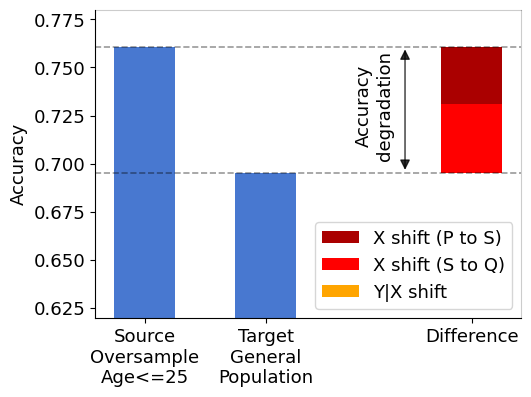

In [4]:
plt.rcParams.update({'font.size': 13})
ax = plot_decomp_bar(decomp, ['Source\nOversample\nAge<=25','Target\nGeneral\nPopulation'])
ax.set_ylim(0.62,0.78);
plt.show()

# calibration

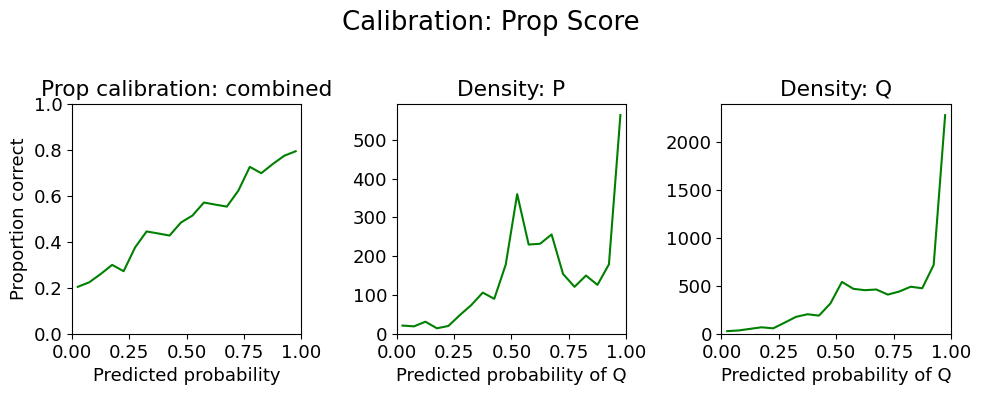

In [5]:
plot_calibration(pi[eval_data.t==0], pi[eval_data.t==1])

# balance

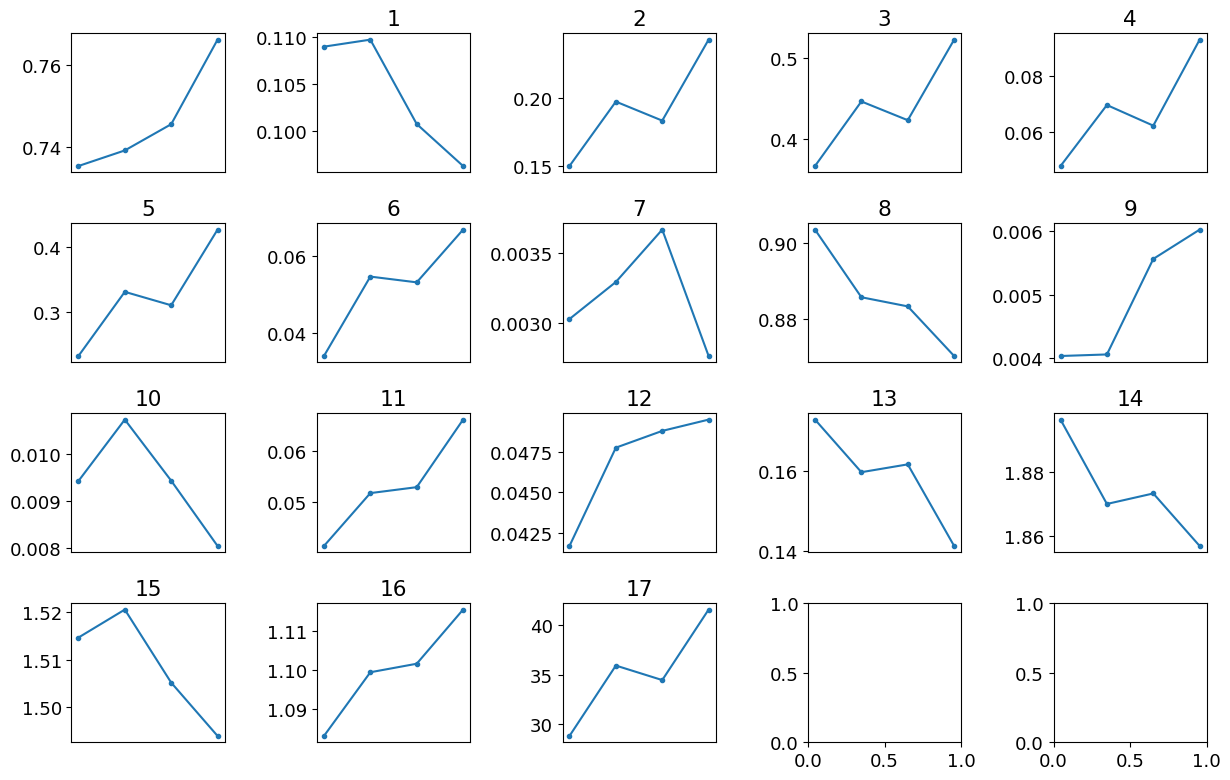

In [6]:
w = get_overlap_weights(eval_data, pi)
plot_balance(eval_data, w)